In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


np.random.seed(0)

## Подготовка данных

1. Удалим из текста HTML разметку.
2. Выполним стэмминг.

In [2]:
train = pd.read_csv("labeledTrainData.tsv", header=0, 
                    delimiter="\t", quoting=3)

unlabeled_train = pd.read_csv("unlabeledTrainData.tsv", header=0, 
                              delimiter="\t", quoting=3)

validation = pd.read_csv("testData.tsv", header=0, 
                         delimiter="\t", quoting=3)

In [3]:
print(train.columns, unlabeled_train.columns, validation.columns)
print(train.shape, unlabeled_train.shape, validation.shape)

Index(['id', 'sentiment', 'review'], dtype='object') Index(['id', 'review'], dtype='object') Index(['id', 'review'], dtype='object')
(25000, 3) (50000, 2) (25000, 2)


In [4]:
all_data = pd.concat([train['review'], unlabeled_train['review'], validation['review']], axis=0)
all_data.shape

(100000,)

In [5]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
from bs4 import BeautifulSoup  
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer


stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'[\w\']+')
stop_words = set(stopwords.words("english") )


def review_to_clean_sentences(raw_review, remove_sw=True):
    review_text = BeautifulSoup(raw_review).get_text() 
    # 1. разбиваем на предложения
    review_text = nltk.sent_tokenize(review_text)
    # 2. каждое предложение разбиваем на токены
    review_text = [tokenizer.tokenize(s) for s in review_text]
    # удаляем стоп слова
    if remove_sw:
        review_text = [ [w for w in s if w.lower() not in stop_words] for s in review_text ]
    # 3. приводим к нижнему регистру и выполняем стэмминг
    review_text = [ [stemmer.stem(w.lower()) for w in s] for s in review_text ]
    
    return review_text   

In [7]:
train_sents = [ review_to_clean_sentences(raw_review) for raw_review in all_data.values]

## Word2Vec

Построим word2vec модель. Полученные вектора будут использованы далее для обучения предсказательных моделей.

In [8]:
sentences = [s for review in train_sents for s in review]

In [9]:
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words


from gensim.models import word2vec


model = word2vec.Word2Vec(sentences, workers=num_workers,
                          size=num_features, min_count = min_word_count,
                          window = context, sample = downsampling)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

In [10]:
model.most_similar("bad")

[('terribl', 0.646848201751709),
 ('horribl', 0.6118679642677307),
 ('lousi', 0.5955506563186646),
 ('crappi', 0.5906460881233215),
 ('good', 0.5836952924728394),
 ('aw', 0.5729691982269287),
 ('stupid', 0.5273633003234863),
 ('suck', 0.5216744542121887),
 ('atroci', 0.5099819302558899),
 ('cheesi', 0.5031810998916626)]

In [11]:
vocab_size = len(model.vocab)
vocab_size

14509

In [12]:
word_to_id = dict(zip(model.vocab.keys(), range(vocab_size)))

In [13]:
PAD = "<PAD>"

word_to_id[PAD] = vocab_size
vocab_size += 1

Преобразуем каждое ревью в последовательность слов. Чтобы все ревью имели одинаковую длину делаем padding.

In [14]:
def sentence_to_seq(sentence):
    return np.array([word_to_id[w] for w in sentence if w in word_to_id], dtype=int)

def review_to_seq(review, max_len):
    seq = np.hstack([sentence_to_seq(s) for s in review])
    if len(seq) < max_len:
        seq = np.hstack([seq, np.full(max_len - len(seq), word_to_id[PAD], dtype=int)])
    elif len(seq) > max_len:
        seq = seq[:max_len]
    return seq

Посмотрим на максимальную длинну ревью и на boxplot.

Мы видим, что несмотря на то, что максимальная длина имеет большое значение, 87.5 процентов ревью имеют длину не более 400 слов.

In [15]:
def review_len(review):
    return np.sum([len(s) for s in review])

max_len = np.max([review_len(review) for review in train_sents])
max_len

1444

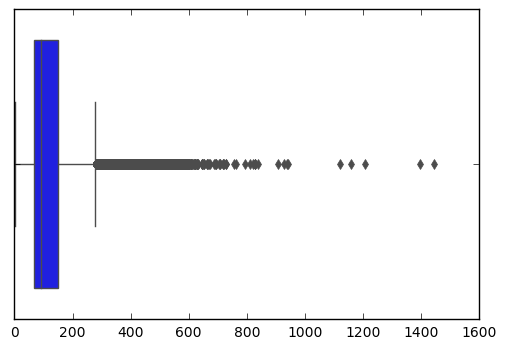

In [16]:
import seaborn as sns


sns.boxplot([np.sum([len(s) for s in review]) for review in train_sents])

In [17]:
long_reviews = [review for review in train_sents if review_len(review) >= 400]
print(len(long_reviews), len(train_sents))

2477 100000


In [18]:
max_len = 400

Построим обучающую выборку, и выполним one-hot кодирование label'ов.

In [19]:
X = [review_to_seq(review, max_len) for review in train_sents[:train.shape[0]]]

In [20]:
X = np.array(X)
X.shape

(25000, 400)

Мы видим, что в обучающей выборке классы имеют равные пропорции, следовательно, нет необходимости в использовании стратификации при разбиение на train/test.

In [21]:
len(train[train['sentiment']==0])

12500

In [22]:
y = train['sentiment']

In [23]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [24]:
y_one_hot = dense_to_one_hot(y, 2).astype(np.uint8)

In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.20, random_state=42)

Воспользуемся обученной word2vec моделью для того, чтобы построить embedding матрицу для слов.

In [26]:
embedding = np.empty(shape=(vocab_size, num_features))

for w,i in word_to_id.items():
    if w == PAD:
        embedding[i] = np.zeros(num_features)
    else:
        embedding[i] = model[w]
    
embedding.shape

(14510, 300)

## Convolutional NN

Попробуем в качестве классификатора использовать сверточную НС.

<img src="conv.png" style="width: 500px;">

In [56]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(self, 
                 sequence_length, 
                 num_classes, 
                 vocab_size,
                 embedding_size, 
                 filter_sizes, 
                 num_filters, 
                 pre_trained_embedding=True, 
                 trainable=False):
        
        self.placeholders(sequence_length, num_classes, vocab_size, embedding_size, pre_trained_embedding)
        self.embedding_layer(vocab_size, embedding_size, pre_trained_embedding, trainable)
        self.conv_and_poll(sequence_length, embedding_size, filter_sizes, num_filters)
        self.dropout()
        self.scores_and_predictions(num_classes)
        self.loss_and_accuracy()
        
        
    # Placeholders for input, output and dropout
    def placeholders(self, sequence_length, num_classes, vocab_size, embedding_size, pre_trained_embedding):
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        
        if pre_trained_embedding:
            self.embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_size], name="embedding")
    
    
    # Embedding Layer
    def embedding_layer(self, vocab_size, embedding_size, pre_trained_embedding, trainable):
        with tf.name_scope("embedding"):
            if pre_trained_embedding:
                self.W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_size]),
                                trainable=trainable, name="W")

                # init embedding
                self.embedding_init = self.W.assign(self.embedding_placeholder)
            else:
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
            
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)
       
    
    # Convolution & Pooling Layer
    def conv_and_poll(self, sequence_length, embedding_size, filter_sizes, num_filters):
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Max-pooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        self.num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(3, pooled_outputs)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, self.num_filters_total])
      
    
    # Add dropout
    def dropout(self):
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
     
    
    # Scores & Predictions
    def scores_and_predictions(self, num_classes):
        with tf.name_scope("output"):
            W = tf.Variable(tf.truncated_normal([self.num_filters_total, num_classes], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
    
    
    # Loss & Accuracy
    def loss_and_accuracy(self):
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            self.loss = tf.reduce_mean(losses)
            
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

### Training

In [28]:
cnn = TextCNN(
    sequence_length=max_len,
    num_classes=2,
    vocab_size=vocab_size,
    embedding_size=num_features,
    filter_sizes=[3, 4, 5],
    num_filters=128, 
    pre_trained_embedding=False)

In [29]:
epochs_completed = 0
index_in_epoch = 0
num_examples = X_train.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global X_train
    global y_train
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return X_train[start:end], y_train[start:end]

In [30]:
train_op = tf.train.AdamOptimizer(1e-4).minimize(cnn.loss)

session_conf = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=session_conf)
sess.run(tf.initialize_all_variables())

In [31]:
def train_step(x_batch, y_batch, dropout_keep_prob):
    feed_dict = {
      cnn.input_x: x_batch,
      cnn.input_y: y_batch,
      cnn.dropout_keep_prob: dropout_keep_prob
    }
    sess.run([train_op], feed_dict)
    
def eval_step(x_batch, y_batch, dropout_keep_prob):
    feed_dict = {
      cnn.input_x: x_batch,
      cnn.input_y: y_batch,
      cnn.dropout_keep_prob: dropout_keep_prob
    }
    return sess.run([cnn.accuracy], feed_dict)[0]
    
def train_loop(num_steps=2000, dropout_keep_prob=0.5):
    for i in range(num_steps):
        batch_xs, batch_ys = next_batch(50)

        if i % 100 == 0:
            train_accuracy = eval_step(batch_xs, batch_ys, dropout_keep_prob)
            print('step %d, training accuracy %g' % (i, train_accuracy))

        train_step(batch_xs, batch_ys, dropout_keep_prob)

In [32]:
train_loop(num_steps=15000)

step 0, training accuracy 0.54
step 100, training accuracy 0.66
step 200, training accuracy 0.5
step 300, training accuracy 0.54
step 400, training accuracy 0.54
step 500, training accuracy 0.52
step 600, training accuracy 0.64
step 700, training accuracy 0.76
step 800, training accuracy 0.5
step 900, training accuracy 0.58
step 1000, training accuracy 0.62
step 1100, training accuracy 0.6
step 1200, training accuracy 0.66
step 1300, training accuracy 0.58
step 1400, training accuracy 0.64
step 1500, training accuracy 0.52
step 1600, training accuracy 0.64
step 1700, training accuracy 0.8
step 1800, training accuracy 0.68
step 1900, training accuracy 0.56
step 2000, training accuracy 0.52
step 2100, training accuracy 0.7
step 2200, training accuracy 0.56
step 2300, training accuracy 0.46
step 2400, training accuracy 0.7
step 2500, training accuracy 0.62
step 2600, training accuracy 0.66
step 2700, training accuracy 0.74
step 2800, training accuracy 0.58
step 2900, training accuracy 0.6

In [36]:
train_loop(num_steps=4000)

step 0, training accuracy 0.92
step 100, training accuracy 0.8
step 200, training accuracy 0.86
step 300, training accuracy 0.94
step 400, training accuracy 0.94
step 500, training accuracy 0.88
step 600, training accuracy 0.94
step 700, training accuracy 0.84
step 800, training accuracy 0.98
step 900, training accuracy 0.94
step 1000, training accuracy 0.94
step 1100, training accuracy 0.86
step 1200, training accuracy 0.98
step 1300, training accuracy 0.98
step 1400, training accuracy 0.94
step 1500, training accuracy 0.92
step 1600, training accuracy 0.9
step 1700, training accuracy 0.88
step 1800, training accuracy 0.92
step 1900, training accuracy 0.98
step 2000, training accuracy 0.94
step 2100, training accuracy 0.98
step 2200, training accuracy 1
step 2300, training accuracy 0.98
step 2400, training accuracy 0.98
step 2500, training accuracy 0.92
step 2600, training accuracy 0.88
step 2700, training accuracy 0.9
step 2800, training accuracy 0.92
step 2900, training accuracy 0.9

### Evaluation

In [33]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def predict_proba(X):
    scores = np.zeros((X.shape[0], 2))
    for i in range(X.shape[0] // 50):
        feed_dict={cnn.input_x: X[i*50 : (i+1)*50], cnn.dropout_keep_prob: 0.5}
        
        scores[i*50 : (i+1)*50,] = sess.run(cnn.scores, feed_dict)

    return np.array([softmax(s) for s in scores])

In [34]:
# feed_dict = {
#     cnn.input_x: X_test,
#     cnn.input_y: y_test,
#     cnn.dropout_keep_prob: 0.5
# }

# print(sess.run(cnn.accuracy, feed_dict))

In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predict_proba(X_test))

0.91023289505201821

In [52]:
def make_submission(preds):
    validation_ids = np.array([i[1:-1] for i in validation['id'].values])
    result = pd.concat([pd.DataFrame(validation_ids ,columns=['id']), 
                        pd.DataFrame(preds ,columns=['sentiment']).astype(int)], axis=1)
    result.to_csv('submission.csv', index=False)

In [39]:
X_validate = [review_to_seq(review, max_len) for review in train_sents[train.shape[0] + unlabeled_train.shape[0]:]]
X_validate = np.array(X_validate)
X_validate.shape

(25000, 400)

In [40]:
def predictions(X):
    preds = np.zeros(X.shape[0])
    for i in range(X.shape[0] // 50):
        feed_dict={cnn.input_x: X[i*50 : (i+1)*50], cnn.dropout_keep_prob: 0.5}
        preds[i*50 : (i+1)*50] = sess.run(cnn.predictions, feed_dict)
    return preds
    

preds = predictions(X_validate)
make_submission(preds)

In [53]:
sess.close()

### Pre-trained Embedding

Выполним инициализацию embedding матрицы, используя word2vec модель, которую мы обучили ранее.

In [57]:
cnn = TextCNN(
    sequence_length=max_len,
    num_classes=2,
    vocab_size=vocab_size,
    embedding_size=num_features,
    filter_sizes=[3, 4, 5],
    num_filters=128, 
    pre_trained_embedding=True, 
    trainable=True)

In [58]:
train_op = tf.train.AdamOptimizer(1e-4).minimize(cnn.loss)

session_conf = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=session_conf)
sess.run(tf.initialize_all_variables())

sess.run(cnn.embedding_init, feed_dict={cnn.embedding_placeholder: embedding})

array([[ 0.02092806,  0.0831697 , -0.07886622, ..., -0.09528812,
         0.04146958,  0.00389927],
       [-0.06520111,  0.02616222, -0.01434479, ...,  0.03417772,
         0.03332462, -0.04156829],
       [ 0.08883546, -0.0441605 ,  0.03837937, ..., -0.01707793,
        -0.09630706,  0.02613185],
       ..., 
       [ 0.03836618,  0.01997105, -0.07133908, ...,  0.14455603,
         0.04657643,  0.04528135],
       [ 0.02618262, -0.03219948, -0.04955882, ..., -0.00354062,
        -0.08708408, -0.12547544],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [59]:
train_loop(num_steps=4000)

step 0, training accuracy 0.4
step 100, training accuracy 0.58
step 200, training accuracy 0.72
step 300, training accuracy 0.74
step 400, training accuracy 0.74
step 500, training accuracy 0.66
step 600, training accuracy 0.72
step 700, training accuracy 0.72
step 800, training accuracy 0.86
step 900, training accuracy 0.84
step 1000, training accuracy 0.72
step 1100, training accuracy 0.82
step 1200, training accuracy 0.86
step 1300, training accuracy 0.86
step 1400, training accuracy 0.86
step 1500, training accuracy 0.84
step 1600, training accuracy 0.86
step 1700, training accuracy 0.86
step 1800, training accuracy 0.94
step 1900, training accuracy 0.96
step 2000, training accuracy 0.88
step 2100, training accuracy 0.94
step 2200, training accuracy 0.94
step 2300, training accuracy 0.86
step 2400, training accuracy 0.9
step 2500, training accuracy 0.9
step 2600, training accuracy 0.84
step 2700, training accuracy 0.92
step 2800, training accuracy 0.82
step 2900, training accuracy 

In [60]:
roc_auc_score(y_test, predict_proba(X_test))

0.93917344665827907

In [61]:
preds = predictions(X_validate)
make_submission(preds)

In [62]:
train_loop(num_steps=2000)

step 0, training accuracy 0.96
step 100, training accuracy 0.96
step 200, training accuracy 0.92
step 300, training accuracy 0.92
step 400, training accuracy 0.94
step 500, training accuracy 0.96
step 600, training accuracy 0.94
step 700, training accuracy 0.96
step 800, training accuracy 0.92
step 900, training accuracy 0.98
step 1000, training accuracy 0.96
step 1100, training accuracy 0.96
step 1200, training accuracy 0.96
step 1300, training accuracy 0.96
step 1400, training accuracy 0.96
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 1
step 1800, training accuracy 1
step 1900, training accuracy 0.96


In [63]:
roc_auc_score(y_test, predict_proba(X_test))

0.94753536964295049

In [64]:
preds = predictions(X_validate)
make_submission(preds)

In [66]:
sess.close()

## Character Level Convolutional NN

## Recurrent NN

Рекуррентная НС с LSTM ячейками.

In [111]:
class RNN(object):
    def __init__(self, 
                 max_length, 
                 num_classes, 
                 units_cnt,
                 vocab_size,
                 embedding_size, 
                 batch_size, 
                 pre_trained_embedding):
        
        self.input_x = tf.placeholder(tf.int32, [batch_size, max_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [batch_size, num_classes], name="input_y")
        self.seq_len = tf.placeholder(tf.int32, [batch_size], name="seq_len")
        
        if pre_trained_embedding:
            self.embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_size], name="embedding")
        
        with tf.name_scope("embedding"):
            if pre_trained_embedding:
                self.W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_size]),
                                     trainable=True, name="W")

                # init embedding
                self.embedding_init = self.W.assign(self.embedding_placeholder)
            else:
                self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            
        with tf.variable_scope("lstm1"):
            self.lstm_cell = tf.nn.rnn_cell.LSTMCell(units_cnt)
            self.value, _ = tf.nn.dynamic_rnn(self.lstm_cell, self.embedded_chars, 
                                              sequence_length=self.seq_len, dtype=tf.float32)
        
        with tf.name_scope("output"):
            W = tf.Variable(tf.truncated_normal([units_cnt, num_classes]))
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            
            self.value = tf.transpose(self.value, [1, 0, 2])
            
            last = tf.gather(self.value, int(self.value.get_shape()[0]) - 1)
            self.scores = tf.nn.xw_plus_b(last, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            self.loss = tf.reduce_mean(losses)
            
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [112]:
BATCH_SIZE = 50

rnn = RNN(max_length=max_len, 
          num_classes=2, 
          units_cnt=max_len,
          vocab_size=vocab_size,
          embedding_size=num_features, 
          batch_size=BATCH_SIZE, 
          pre_trained_embedding=True)

### Training

In [81]:
def sentence_len(s):
    i, = np.where(s == word_to_id[PAD])
    return len(s) if len(i) == 0 else i[0] + 1

In [83]:
seq_len_train = np.array([sentence_len(s) for s in X_train])
seq_len_test = np.array([sentence_len(s) for s in X_test])

In [84]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
            
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [114]:
train_op = tf.train.AdamOptimizer(1e-4).minimize(rnn.loss)

session_conf = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=session_conf)
sess.run(tf.initialize_all_variables())

In [115]:
sess.run(rnn.embedding_init, feed_dict={rnn.embedding_placeholder: embedding})

array([[ 0.02092806,  0.0831697 , -0.07886622, ..., -0.09528812,
         0.04146958,  0.00389927],
       [-0.06520111,  0.02616222, -0.01434479, ...,  0.03417772,
         0.03332462, -0.04156829],
       [ 0.08883546, -0.0441605 ,  0.03837937, ..., -0.01707793,
        -0.09630706,  0.02613185],
       ..., 
       [ 0.03836618,  0.01997105, -0.07133908, ...,  0.14455603,
         0.04657643,  0.04528135],
       [ 0.02618262, -0.03219948, -0.04955882, ..., -0.00354062,
        -0.08708408, -0.12547544],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [120]:
t_data = list(zip(X_train, y_train, seq_len_train))

In [121]:
def train_step(x_batch, y_batch, seq_len):
    feed_dict = {
      rnn.input_x: x_batch,
      rnn.input_y: y_batch,
      rnn.seq_len: seq_len
    }
    sess.run([train_op], feed_dict)
    
def eval_step(x_batch, y_batch, seq_len):
    feed_dict = {
      rnn.input_x: x_batch,
      rnn.input_y: y_batch,
      rnn.seq_len: seq_len
    }
    return sess.run([rnn.accuracy], feed_dict)[0]
    
def train_loop(e_cnt=4, evaluate_every=100):
    batches = batch_iter(t_data, BATCH_SIZE, e_cnt)
    
    i = 0
    for batch in batches:
        batch_xs, batch_ys, batch_seq_len = zip(*batch)

        if i % evaluate_every == 0:
            train_accuracy = eval_step(batch_xs, batch_ys, batch_seq_len)
            print('step %d, training accuracy %g' % (i, train_accuracy))

        train_step(batch_xs, batch_ys, batch_seq_len)
        i += 1

In [122]:
train_loop()

step 0, training accuracy 0.52
step 100, training accuracy 0.66
step 200, training accuracy 0.5
step 300, training accuracy 0.44
step 400, training accuracy 0.52
step 500, training accuracy 0.58
step 600, training accuracy 0.38
step 700, training accuracy 0.54
step 800, training accuracy 0.46
step 900, training accuracy 0.48
step 1000, training accuracy 0.56
step 1100, training accuracy 0.56
step 1200, training accuracy 0.64
step 1300, training accuracy 0.52
step 1400, training accuracy 0.58
step 1500, training accuracy 0.58


In [124]:
train_loop(40)

step 0, training accuracy 0.36
step 100, training accuracy 0.38
step 200, training accuracy 0.54
step 300, training accuracy 0.54
step 400, training accuracy 0.58
step 500, training accuracy 0.56
step 600, training accuracy 0.38
step 700, training accuracy 0.5
step 800, training accuracy 0.48
step 900, training accuracy 0.54
step 1000, training accuracy 0.3
step 1100, training accuracy 0.44
step 1200, training accuracy 0.54
step 1300, training accuracy 0.4
step 1400, training accuracy 0.6
step 1500, training accuracy 0.64
step 1600, training accuracy 0.5
step 1700, training accuracy 0.62
step 1800, training accuracy 0.54
step 1900, training accuracy 0.62
step 2000, training accuracy 0.46
step 2100, training accuracy 0.48
step 2200, training accuracy 0.6
step 2300, training accuracy 0.56
step 2400, training accuracy 0.52
step 2500, training accuracy 0.6
step 2600, training accuracy 0.56
step 2700, training accuracy 0.58
step 2800, training accuracy 0.56
step 2900, training accuracy 0.5


KeyboardInterrupt: 